# ZEMAX Rayfile Generation
---
### IQA
Far field focal length lens = 80mm

Near field magnification = 1

['100dc.txt', 'FF CW Full Module_0001.ascii.csv', 'NF CW Full Module_0001.ascii.csv']


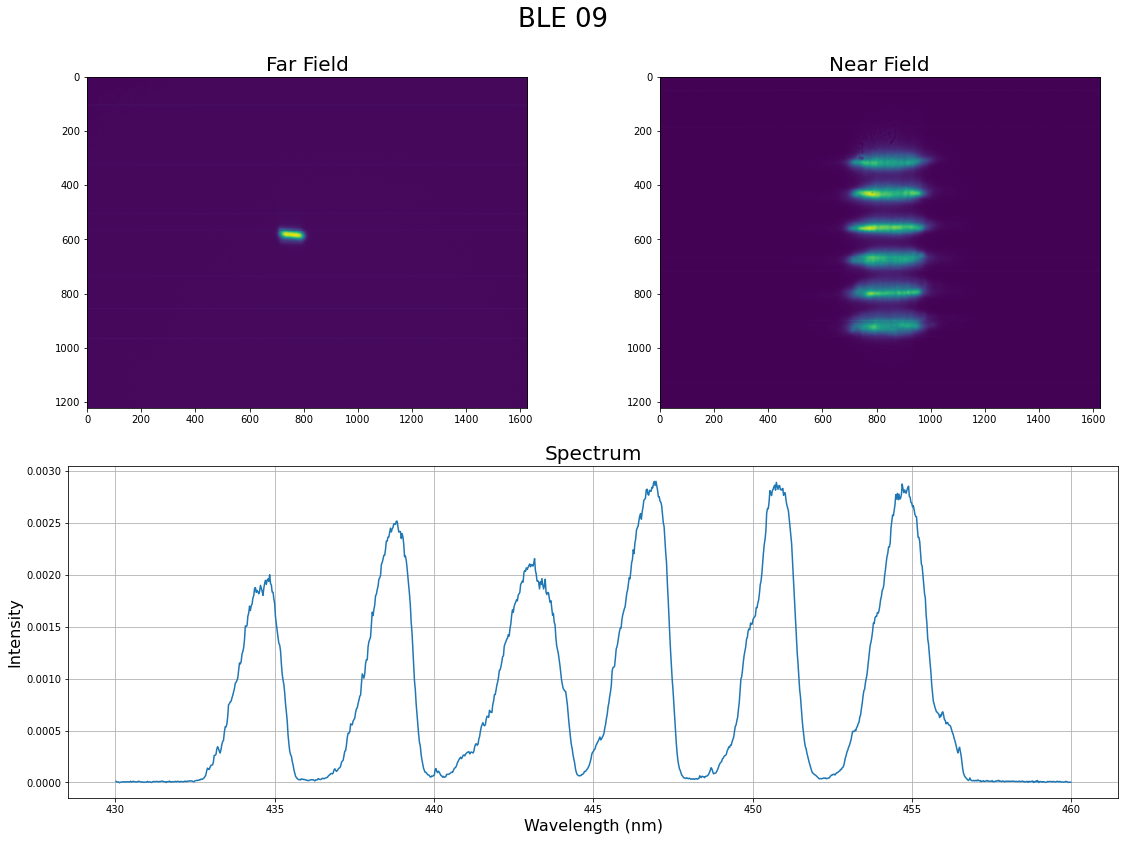

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sys
sys.path.append('../') # Needed for import
import laserbeamtools as lbt

# Plot title
title = 'BLE 09'

# Create a list of the files
folder = r'../tests/test_beam_profiles/For_Rayfile_Gen/09'
print(os.listdir(folder))

# Far field images
# ff1_file = '/'.join([folder,r'FF CW Row 1&2_0001.ascii.csv'])
# ff2_file = '/'.join([folder,r'FF CW Row 3&4_0001.ascii.csv'])
# ff1 = lbt.load_img(ff1_file)
# ff2 = lbt.load_img(ff2_file)
# ff = ((ff1/np.sum(ff1)) + (ff2/np.sum(ff2))) * 0.5
ff1_file = '/'.join([folder,r'FF CW Full Module_0001.ascii.csv'])
ff1 = lbt.load_img(ff1_file)
ff = ff1/np.sum(ff1)

# Near field images
# nf1_file = '/'.join([folder,r'NF CW Row 1&2_0001.ascii.csv'])
# nf2_file = '/'.join([folder,r'NF CW Row 3&4_0001.ascii.csv'])
# nf1 = lbt.load_img(nf1_file)
# nf2 = lbt.load_img(nf2_file)
# nf = ((nf1/np.sum(nf1)) + (nf2/np.sum(nf2))) * 0.5
nf1_file = '/'.join([folder,r'NF CW Full Module_0001.ascii.csv'])
nf1 = lbt.load_img(nf1_file)
nf = nf1/np.sum(nf1)

# Spectrum
spectrum_file = '/'.join([folder, r'100dc.txt'])

# generate lists
spectrum = lbt.open_spectrum(spectrum_file)
spec_x = spectrum[0]
spec_y = spectrum[1]

# Trim spectrum file
indexs = (spec_x < 460) & (spec_x > 430)
spec_x_t = spec_x[indexs]
spec_y_t = spec_y[indexs]
spectrum_t = [spec_x_t, spec_y_t]

# Plot data
fig = plt.figure(figsize=(16,12))

gs0 = gridspec.GridSpec(2, 1, figure=fig)
gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0])

ax1 = fig.add_subplot(gs00[0])
ax1.imshow(ff)
ax1.set_title('Far Field', fontsize=20)
# ax1.tick_params(labelbottom=False, labelleft=False)

ax2 = fig.add_subplot(gs00[1])
ax2.imshow(nf)
ax2.set_title('Near Field', fontsize=20)
# ax2.tick_params(labelbottom=False, labelleft=False)

ax3 = fig.add_subplot(gs0[1])
ax3.plot(spec_x_t, spec_y_t)
ax3.grid('on')
ax3.set_title('Spectrum', fontsize=20)
ax3.set_xlabel('Wavelength (nm)', fontsize = 16)
ax3.set_ylabel('Intensity', fontsize = 16)

plt.suptitle(title, fontsize = 26)
fig.tight_layout(pad=2)

plt.show()

# Crop And Center The Far Field Image
---
Run `beam_size()` to determine beam parameters.

Run `subtract_corner_background()` with `iso_noise=False` to subtract the background and zero all pixels below a certain threshold.

Run `crop_image_to_integration_rect()` to reduce the size of the image.

Must also verify that `beam_size()` found the correct parameters, this can be easily done by looking at the output of `plot_image_analysis()`.

`ff_c` is our new far field array. 

The center of the beam ellipse is at (430, 340)
The ellipse diameter (closest to horizontal) is 116 pixels
The ellipse diameter (closest to   vertical) is 64 pixels
The ellipse is rotated -6° ccw from the horizontal


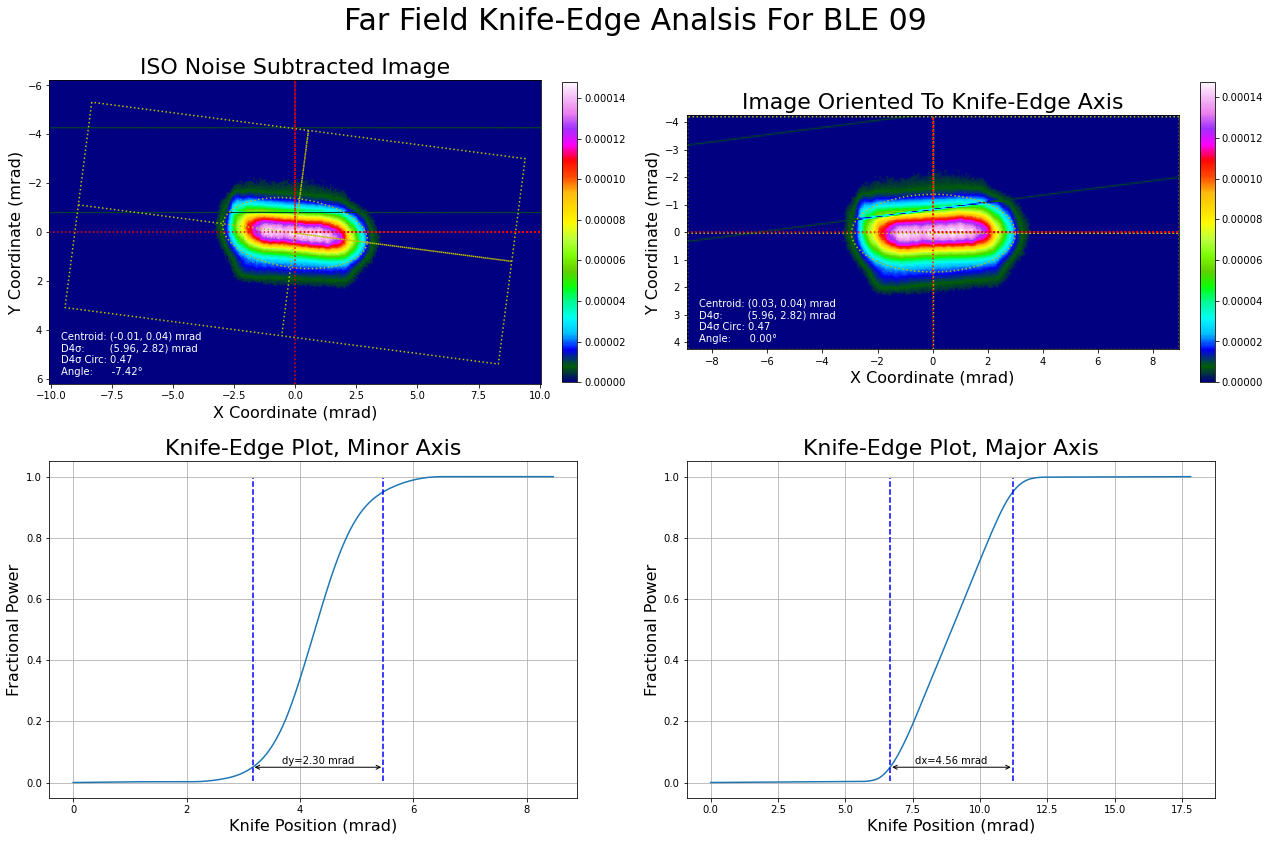

In [8]:
# Parse beam
def crop(img, crop_frac=0.2):
    # Input image
    vv,hh = img.shape
    vd = int(vv * crop_frac)
    hd = int(hh * crop_frac)
    return img[vd:(vv-vd), hd:(hh-hd)]

ff2 = crop(ff)

x, y, dx, dy, phi = lbt.beam_size(ff2)
print("The center of the beam ellipse is at (%.0f, %.0f)" % (x, y))
print("The ellipse diameter (closest to horizontal) is %.0f pixels" % dx)
print("The ellipse diameter (closest to   vertical) is %.0f pixels" % dy)
print("The ellipse is rotated %.0f° ccw from the horizontal" % (phi * 180/3.1416))

ff_nbg = lbt.subtract_corner_background(ff2, iso_noise=False)

ff_c, ffx_c, ffy_c = lbt.crop_image_to_integration_rect(ff_nbg, x, y, dx, dy, phi)

flen = 80 # mm
pixel_size=4.4 # um
# lbt.plot_image_analysis(ff_c, pixel_size=pixel_size/flen, units='mrad',title='Knife-Edge Analsis For %s' % title)
lbt.plot_knife_edge_analysis(ff_c, pixel_size=pixel_size/flen, units='mrad',title='Far Field Knife-Edge Analsis For %s' % title)

# Crop And Center The Near Field
---
Repeat the same steps for near field image.

`nf_c` is our new near field array.

The center of the beam ellipse is at (839, 612)
The ellipse diameter (closest to horizontal) is 310 pixels
The ellipse diameter (closest to   vertical) is 836 pixels
The ellipse is rotated -0° ccw from the horizontal


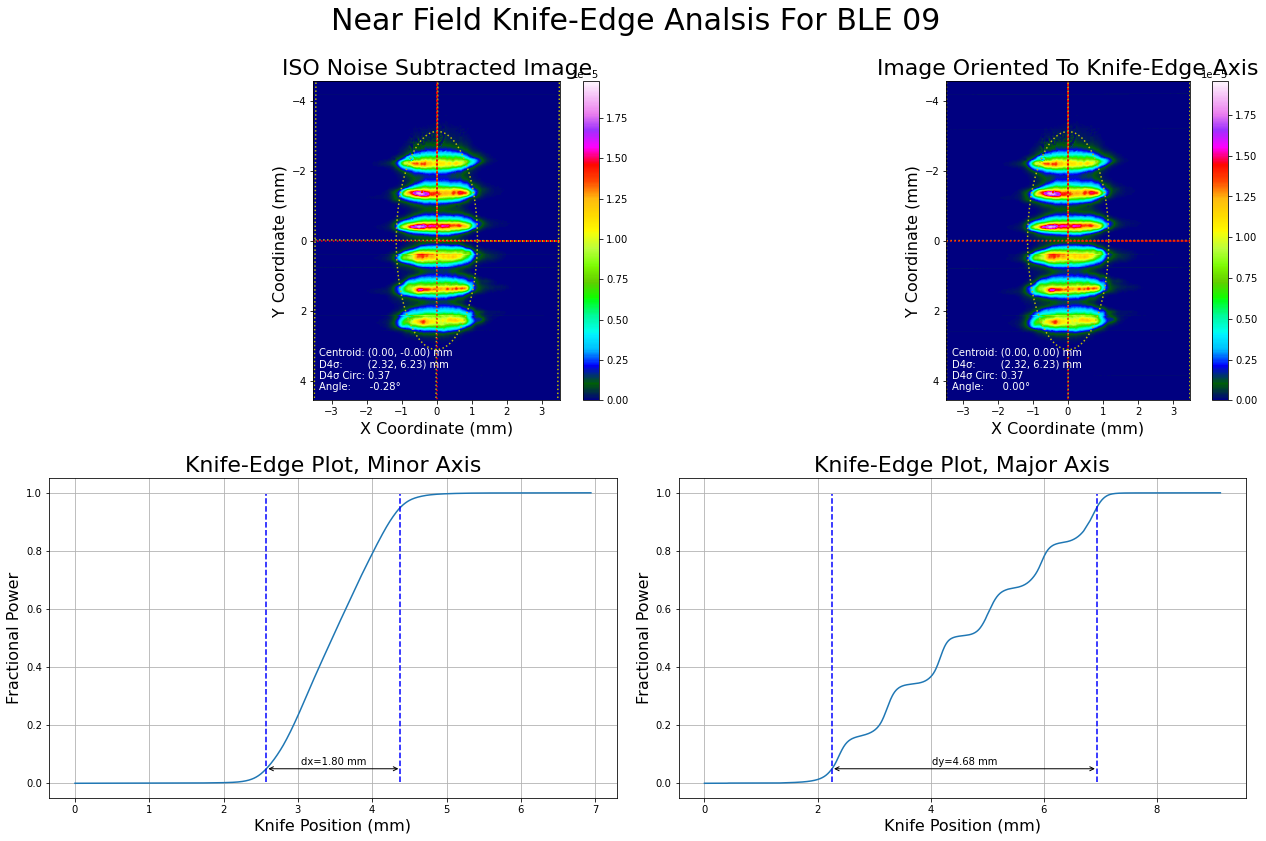

In [9]:
# Parse beam
x, y, dx, dy, phi = lbt.beam_size(nf)
print("The center of the beam ellipse is at (%.0f, %.0f)" % (x, y))
print("The ellipse diameter (closest to horizontal) is %.0f pixels" % dx)
print("The ellipse diameter (closest to   vertical) is %.0f pixels" % dy)
print("The ellipse is rotated %.0f° ccw from the horizontal" % (phi * 180/3.1416))

nf_nbg = lbt.subtract_corner_background(nf, iso_noise=False)
nf_c, nfx_c, nfy_c = lbt.crop_image_to_integration_rect(nf_nbg, x, y, dx, dy, phi)

pixel_size=4.4
mag = 0.59
lbt.plot_knife_edge_analysis(nf_c, pixel_size=pixel_size/mag/1000, units='mm',title='Near Field Knife-Edge Analsis For %s' % title)

# Generate The Rayfile
---

In [4]:
rg = lbt.Rayfile_gen()
rg.load_nf(nf_c, pixel_size_um=4.4, magnification=0.59)
rg.load_ff(ff_c, pixel_size_um=4.4, flen_mm=80)

# Set wavelength to single value
spec_x_t = [0.455]
spec_y_t = [1]

rg.load_spectrum(spec_x_t, spec_y_t)
rg.generate('BLE_09.DAT')

1.0000000000000027
Generating rayfile, this may take some time...
Radomizing ray order...
Rayfile succesfully generated, saved under:
	BLE_09.DAT


# Matrix Math Optimization

In [13]:
sys.path.append('../') # Needed for import
import laserbeamtools as lbs

import random

class Weighted_far_field:
    """
    A class representing an employee.
 
    Attributes:
        ff (numpy array): pixel array from the far field camera.
        v (list): list off all unit vectors built from the far field image.
    """

    def __init__(self, 
                 ff_img, 
                 pixel_size_um=4.4, 
                 flen_mm=80, 
                 floor=0):
        """
        Initialize the Weighted_far_field object.

        Args:
            ff_img: far field array
            pixel_size: camera pixel size, must be in um
            flen: far field lens effective focal length, must also be in um 
            floor: floor value that a pixel must exceed to be considered for a vector
        """
        # TODO:
        # Floor option
        
        # Convert flen to um
        flen = flen_mm * 1000 #um
        
        # Copy input array and normalize
        self.ff = np.copy(ff_img)
        self.ff = self.ff/np.sum(self.ff)

        # Flatten array
        self.ff_flat = self.ff.flatten()

        # Generate index list
        self.i = np.linspace(0, len(self.ff_flat), len(self.ff_flat), endpoint=False, dtype=int)
        
        # Camera shape and scaled values
        vv, hh = self.ff.shape
        self.s = pixel_size_um / flen
        h_s = hh * self.s
        v_s = vv * self.s

        # Create index arrays (vi : vertical index array) (hi : horizontal index array)
        vi, hi = (np.indices(self.ff.shape))

        # Index arrays (vi_s : vertical index scaled) (hi_s : horizontal index scaled)
        vi_s = (vi * self.s) - (v_s / 2)
        hi_s = (hi * self.s) - (h_s / 2)

        # Projection of vectors
        z_proj = (1 + hi_s**2 + vi_s**2)**(-1/2)
        x_proj = hi_s * z_proj
        y_proj = vi_s * z_proj

        # Flattened arrays
        self.z_proj_flat = z_proj.flatten()
        self.x_proj_flat = x_proj.flatten()
        self.y_proj_flat = y_proj.flatten()

        return

    def get_vectors(self, num):
        """
        Returns a list of vectors chosen by the weighted distribution

        Args:
            num: number of vectors to choose

        Returns:
            x_list: list of x components of unit vectors
            y_list: list of y components of unit vectors
            z_list: list of z components of unit vectors
        """
        indexes = np.random.choice(self.i, num, p=self.ff_flat)
        x_list = self.x_proj_flat[indexes]
        y_list = self.y_proj_flat[indexes]
        z_list = self.z_proj_flat[indexes]

        return x_list, y_list, z_list

    def preview_ff(self) -> None:
        """
        Preview the data from the far field.
        """
        lbs.plot_knife_edge_analysis(self.ff, 
                                     pixel_size=self.s * 1000, 
                                     units='mrad', 
                                     title='Far Field Knife-Edge Analysis')
        return
    
    def preview_dist(self) -> None:
        ff_flat = self.ff.flatten()

        plt.plot(ff_flat)

        return

class Rayfile_gen:
    """
    
    Attributes:
        nf: near field image
        ff: far field image
        wff: weighted far field
    """
    def load_nf(self,
                nf_img, 
                pixel_size_um, 
                magnification,
                quash_noise=True,
                crop=True
                ) -> None:    
        """
        Loads in the near image

        Args:
            nf_img: near field image
            pixel_size_um: pixel size in micron
            magnification: magnification of the image
            quash_noise: (optional) zero all noise below 3*nT
            crop: (optional) crop rectangle to 3*D4sigma fullwidth
        """

        # Near field array
        self.nf = np.copy(nf_img)      

        if quash_noise:
            self.nf = lbs.subtract_corner_background(self.nf, iso_noise=False)

        if crop:
            x, y, dx, dy, phi = lbs.beam_size(self.nf)
            self.nf, _, _ = lbs.crop_image_to_integration_rect(self.nf, x, y, dx, dy, phi)

        # Near field parameters
        self.mag = magnification
        self.pixel_size_um = pixel_size_um   

        # Camera shape
        self.vv, self.hh = self.nf.shape
        self.s = pixel_size_um / magnification
        self.h_s = self.hh * self.s
        self.v_s = self.vv * self.s
        self.x1 = self.h_s / 2
        self.y1 = self.v_s / 2

        return None
    

    def preview_nf(self) -> None:
        """
        Preview data, useful before generating rayfile to ensure proper generation.

        Args:

        """
        lbs.plot_knife_edge_analysis(self.nf, 
                                     pixel_size=self.pixel_size/self.mag/1000, 
                                     units='mm',
                                     title='Near Field Knife-Edge Analsis')
        
        return None


    def load_ff(self,
                ff_img, 
                pixel_size_um, 
                flen_mm,
                floor=0,
                quash_noise=True,
                crop=True,
                precrop=True,
                precrop_frac=0.7
                ) -> None:
        """
        Loads the far field data. All far field data is embedded in the wff object.

        Args:
            ff_img: far field image
            pixel_size: pixel size on the far field camera
            flen_mm: focal length of the lens used to image the beam on the far field camera
            floor: (optional) floor value, only consider pixels above this value
            crop: (optional) crop the beam to 3 time the D4simga fullwidth
            precrop: (optional) crop the beam before finding the D4sigma values used to crop the beam
        """
        ff = np.copy(ff_img)

        if precrop:
            h_frac = precrop_frac/2.0
            vv,hh = ff.shape
            vd = int(vv * h_frac)
            hd = int(hh * h_frac)
            ff = ff[vd:(vv-vd), hd:(hh-hd)]

        if quash_noise:
            ff = lbs.subtract_corner_background(ff, iso_noise=False)

        if crop:
            x, y, dx, dy, phi = lbs.beam_size(ff)
            ff, _, _ = lbs.crop_image_to_integration_rect(ff, x, y, dx, dy, phi)

        self.wff = Weighted_far_field(ff_img=ff, 
                                      pixel_size_um=pixel_size_um, 
                                      flen_mm=flen_mm, 
                                      floor=floor)
        
        return None
        

    def open_spectrum_file(self, 
                           file_name, 
                           delimiter='\t', 
                           skip_start = 1
                           )->None:
        """
        Method to load spectrum data from a text file.

        Args:
            file_name: full file path to file.
            delimiter: delimiters in file.
            skip_start: skip start rows
        
        Returns:
            [wavelengths, intensities]: wavelengths are their corresponding intensities in the signal.
        """
        # Create empty lists for data to be appended to
        x = []
        y = []

        # Open file
        with open(file_name,"r") as file:
            data=file.read()
            dataList = data.split('\n')

            # Loop through rows in file
            for i in range(0,len(dataList)-1):
                
                # Look for rows to skip
                if i >= skip_start:
                    # Split data and append it to lists
                    temp = dataList[i].split(delimiter)
                    x.append(float(temp[0]))
                    y.append(float(temp[1]))

        self.load_spectrum(x,y)
        
        return None


    def load_spectrum(self, 
                      wavelengths, 
                      intensities
                      )->None:
        """
        Method to load spectrum data from a text file.

        Args:
            file_name: full file path to file.
            delimiter: delimiters in file.
            skip_start: skip start rows
        
        Returns:
            [wavelengths, intensities]: wavelengths are their corresponding intensities in the signal.
        """
        # wavelength data
        self.wavelengths = np.asarray(wavelengths)

        # intensity data
        intensities = np.asarray(intensities)

        if np.min(intensities) < 0:
            intensities = intensities - np.min(intensities)

        self.intensities = intensities/np.sum(intensities)        

        return None
        
    def generate(self,
                 output_filename='custom_rayfile.DAT',
                 rays=10000, 
                 )->None:
        """
        Method to actually generate the rayfile.

        Args:
            output_filename:
        """
        print("Generating rayfile, this may take some time...")

        floor = 0

        # generate wavelength array
        # rays = np.sum(self.nf > floor)

        # Weighted random wavelength list
        wl_vals = np.random.choice(self.wavelengths, rays, p=self.intensities)/1000 # wavelength in micron

        # Weighted random ray unit vector lists
        vx, vy, vz = self.wff.get_vectors(rays)

        # flattened near field
        self.nf_flat = self.nf.flatten()
        self.nf_flat = self.nf_flat / np.sum(self.nf_flat)

        # Create an index list
        self.i = np.linspace(0, len(self.nf_flat), len(self.nf_flat), endpoint=False, dtype=int)

        # Only pick indexes that are above floor value
        i_removed_floor = self.i[self.nf_flat > floor]

        # Weighted random indexes
        indexes = np.random.choice(i_removed_floor, rays)

        # Camera shape and scaled values
        vv, hh = self.nf.shape
        h_s = hh * self.s
        v_s = vv * self.s
        vi, hi = (np.indices(self.nf.shape))
        vi_s = (vi * self.s) - (v_s / 2)
        hi_s = (hi * self.s) - (h_s / 2)
        vi_s_flat = vi_s.flatten()
        hi_s_flat = hi_s.flatten()

        # Randomized lists
        x_coords = hi_s_flat[indexes]/1000 # x coords in mm
        y_coords = vi_s_flat[indexes]/1000 # y coords in mm
        power_vals = self.nf_flat[indexes]

        power_vals = power_vals / np.max(power_vals) # Make max value 1.0

        # Create output file
        with open(output_filename, 'w') as writer:
            
            # Line 1
            writer.write("{} 4\n".format(rays))
            
            # Remaining lines
            for i in range(0,rays):
                line_str = "{:.5f} {:.5f} 0 {:.10f} {:.10f} {:10f} {:.4f} {:.4f}\n".format(x_coords[i], y_coords[i],
                                                                                            vx[i], vy[i], vz[i],
                                                                                            power_vals[i],
                                                                                            wl_vals[i])
                writer.write(line_str)

        print("Rayfile succesfully generated, saved under:\n\t%s" % output_filename)
        
        return None



rg = Rayfile_gen()
rg.load_nf(nf_c, pixel_size_um=4.4, magnification=0.59)
rg.load_ff(ff_c, pixel_size_um=4.4, flen_mm=80)

rg.load_spectrum(spec_x_t, spec_y_t)
rg.generate('test2.DAT', rays=10000)

Generating rayfile, this may take some time...
Rayfile succesfully generated, saved under:
	test2.DAT


In [6]:
import numpy as np
# wff = Weighted_far_field(ff2)
# wff.preview_dist()

ini_array1 = np.array([[1, 2, 1, 1, 1], [2, 4, 2, 2, 10], [1, 2, 1, 4, 5]])

print(ini_array1.shape)


vv, hh = ini_array1.shape
# print('2D Grid from np.indices')
# grid2d = (np.indices(ini_array1.shape)-1)*5

# print(v_i)
# print(h_i)

ini_array2 = ini_array1.flatten()

y = 2
x = 1
print("Coords 2d")
print(y)
print(x)


print(ini_array1[y,x])

# converting 2d coords to 1d coords
i = (y * hh) + x

print(i)
print(ini_array2[i])

print(ini_array1)
print(ini_array2)

# convert 1d coords to 2d coords
hn = i%hh
vn = int(i/hh)
print('2d')
print(hn)
print(vn)

print(ini_array1[vn,hn])

print(ini_array2.shape[0])

a = np.linspace(0, len(ini_array2), len(ini_array2), endpoint=False, dtype=int)
print(a)

print(ini_array2[[1, 3, 2, 6, 1]])


np.sum([ini_array2 > 3])
# v_i = np.indices((1, ini_array2.shape[0]))

# print(v_i)
# print(h_i)
 
# ini_array1 = ini_array1/np.sum(ini_array1)

# # printing initial arrays
# print("initial array", str(ini_array1))
 
# # Multiplying arrays
# result = ini_array1.flatten()

# print('1D')
# grid1d = np.indices(result.shape)
# print(grid1d[0])

# plt.plot(result)
 
# # printing result
# print("New resulting array: ", result)

# wa = np.random.choice(grid1d[0], 10, p=result)

# print(wa)

a = np.asarray([0, 1, 2, 3, 4])

b = np.asarray([1, 1, 0, 5, 1])

c = a[b > 0]
print(c)

(3, 5)
Coords 2d
2
1
2
11
2
[[ 1  2  1  1  1]
 [ 2  4  2  2 10]
 [ 1  2  1  4  5]]
[ 1  2  1  1  1  2  4  2  2 10  1  2  1  4  5]
2d
1
2
2
15
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[2 1 1 4 2]
[0 1 3 4]
